# Préparez des données pour un organisme de santé publique

## Santé publique France

![Santé Publique France](data/images/Sante-publique-France-logo.png)

L'agence "Santé publique France" a lancé un appel à projets pour rendre les données de santé plus accessibles. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.


## Open Food Facts

![Open Food Facts](data/images/OpenFoodFacts.png)

À l’aide des données d’Open Food Facts, nous réaliserons une première exploration et visualisation des données, afin que les agents puissent ensuite s’appuyer sur nos résultats.

### Importations

Importation de bibliothèques et des paramètres.

In [1]:
# Manipulation de données
import warnings
import folium
from IPython import get_ipython
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from branca.colormap import LinearColormap

# Afficher toutes les sorties de cellule
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# extension de chargement automatique
# if 'autoreload' not in ipython.extension_manager.loaded:
#     %load_ext autoreload

# %autoreload 2

warnings.filterwarnings('ignore')

### Fonctions

Fonctions commune

In [2]:
# Calculer le nombre de lignes d'un dataframe spécifique
def get_rows(df):
    rows = df.shape[0]
    return rows


# Retourner les 10 premiers enregistrements par nom de colonne
def get_top_10(df, column_name):
    df_result = df.groupby([
        column_name
    ]).size().reset_index(name='Nombre').sort_values('Nombre',
                                                     ascending=False).head(10)

    rows = get_rows(df)
    df_result['Pourcentage'] = df_result['Nombre'] / rows * 100

    return df_result.copy()


# Compter le nombre de lignes vides pour un dataframe spécifique.
def get_empty_rows(df, column_name):
    return df.query(str(column_name) + '.isnull()').count()


# Afficher le graphique en barre avec le nombre


def show_plot(df, column_name):
    df_plot = df.loc[:, [column_name, 'Nombre']].set_index(
        column_name)['Nombre'].copy()

    plt.figure(figsize=(15, 10))

    sns.set(style="whitegrid")
    g = sns.barplot(df_plot, df_plot.index, orient='h', palette="Blues_d")

    plt.title('Les plus grands ' + column_name, fontsize=20)
    plt.xlabel("Nombre d'occurrences", fontsize=14)
    plt.ylabel(column_name, fontsize=14)

    # Show Number on the right of the bar plot
    for i, v in enumerate(df_plot.values.tolist()):
        g.text(v + 3, i + .25, str(v), color='black', fontweight='normal')

    plt.show()


# Imprimer les principaux éléments de statistiques
def print_stats(df, column_name):
    total_rows = get_rows(df)
    empty_rows = str(df[column_name].isna().sum())
    perc = int(empty_rows) * 100 / int(total_rows)
    print("Nombre d'enregistrements vides pour " + str(column_name) + ': ' +
          str(empty_rows) + ' (' + str(perc) + '%)')
    print(df[column_name].agg(['nunique', 'count', 'size']))

# COMPRENDRE LES DONNÉES

Le but de cette partie est de charger et de comprendre les données fournies par Open Food Facts. Nous aimerions comprendre l'exhaustivité et la fiabilité de ces données.

### Chargement des données
Nous souhaitons charger les données et diviser les fichiers en sous-catégories. Nous aimerions vérifier la taille/forme des ensembles de données et comprendre quelles colonnes pourraient être utilisées pour les agents de Santé publique France. Identifier les lacunes, les NaN. D'une manière ou d'une autre, nous aimerions comprendre la qualité globale des données.

### Qui sont les contributeurs
Nous aimerions vérifier qui sont les contributeurs, qui contribue le plus, si nous pouvons faire confiance à la source et si nous pouvons trouver des références sur le net.

### Quelles sont les marques
Nous voulons vérifier si tous les produits sont assignés à une marque et si toutes ces marques existent (vérification croisée avec wikipedia par exemple).

### Quels sont les pays
Nous voudrions vérifier si tous les produits sont assignés à un Pays (Countries).
Nous n'avous besoins que de produits vendu en France.
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelle est l'origine des produits ?
Nous aimerions vérifier si tous les produits sont affectés à une Origine (Pays).
Comme nous suspectons des doublons et des données non normalisées, ces valeurs doivent être nettoyées.

### Quelles sont les catégories principales
Nous cherchons à savoir quelles sont les catégories principales (nombre/pourcentage/vide).

### Vérifier s'il y a d'autres anomalies dans les données
Jusqu'à présent, il semble que certains produits ont été saisis plusieurs fois.

<div class="alert alert-warning">
Veuillez noter que le fichier a été téléchargé depuis Internet et non depuis OpenClassRooms de manière à assurer la mise à jour et le suivi des données.</div>

Cet ensemble de données contient la valeur nutritive des aliments pour plus de 100 000 produits alimentaires provenant de 150 pays.

![Open Food Facts](data/images/prince.jpg)

Chargement du jeu de données téléchargé à partir de https://static.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv

In [3]:
# Chemin par défaut des données
data_path = 'data/'

In [4]:
# Lire le dossier
df = pd.read_csv(data_path + 'fr.openfoodfacts.org.products.csv',
                 sep="\t",
                 low_memory=False)

## Taille et forme
Contrôle de la taille et de la forme d'Open Food Facts

In [5]:
print('Open Food Facts contient ' + str(get_rows(df)) + ' produits et ' +
      str(df.shape[1]) + ' colonnes')

Open Food Facts contient 1741534 produits et 184 colonnes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741534 entries, 0 to 1741533
Columns: 184 entries, code to carnitine_100g
dtypes: float64(122), int64(2), object(60)
memory usage: 2.4+ GB


In [7]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'abbreviated_product_name', 'generic_name',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=184)

<AxesSubplot:ylabel='None'>

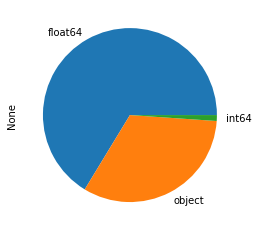

In [8]:
df.dtypes.value_counts().plot.pie()

In [9]:
df.count()

code                  1741534
url                   1741534
creator               1741530
created_t             1741534
created_datetime      1741534
                       ...   
choline_100g               41
phylloquinone_100g       1712
beta-glucan_100g           31
inositol_100g              46
carnitine_100g             20
Length: 184, dtype: int64

In [10]:
df.isnull().sum().sort_values()

code                                           0
url                                            0
created_t                                      0
created_datetime                               0
last_modified_t                                0
                                          ...   
water-hardness_100g                      1741534
no_nutriments                            1741534
allergens_fr                             1741534
cities                                   1741534
ingredients_that_may_be_from_palm_oil    1741534
Length: 184, dtype: int64

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution de NaNs')

Text(0.5, 0, 'NaNs')

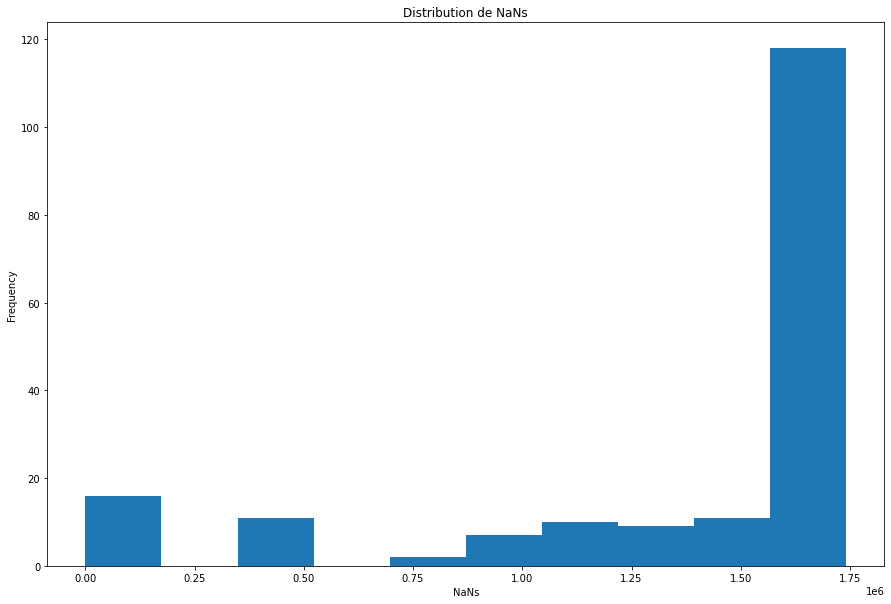

In [11]:
df.isnull().sum().plot(kind='hist', figsize=(15, 10))
plt.title('Distribution de NaNs')
plt.xlabel('NaNs')

plt.show()

### Nettoyage de base sécurisé

Nous pouvons en toute sécurité supprimer les lignes (individus) et les colonnes (variables) sans données ou doublons s'il y en a.

In [12]:
nrows, ncols = df.shape

# Supprimer les lignes sans données.
df.dropna(how='all', inplace=True)

# Supprimer les colonnes sans données.
empty_variables = df.columns[df.isnull().sum() == df.shape[0]]
df.dropna(how='all', axis=1, inplace=True)

# Supprimer les valeurs en double
duplicates_count = df.duplicated().sum()
df.drop_duplicates(inplace=True)

print("Nombre de lignes vides supprimées: {}".format(nrows - df.shape[0]))
print('Nombre de colonnes vides supprimées: {}'.format(len(empty_variables)))
print('Colonnes supprimées:\n{}'.format(empty_variables))
print('Nombre de doublons supprimés: {}'.format(duplicates_count))
print('\nDimensions du jeu de données: {}'.format(df.shape))

Nombre de lignes vides supprimées: 1
Nombre de colonnes vides supprimées: 6
Colonnes supprimées:
Index(['cities', 'allergens_fr', 'no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'water-hardness_100g'],
      dtype='object')
Nombre de doublons supprimés: 1

Dimensions du jeu de données: (1741533, 178)


### Compréhension des données

#### Identification des variables d'objets

Ayons un meilleur aperçu de l'ensemble de données. Parce qu'il y a beaucoup de variables, nous traiterons séparément les variables objet et numériques.

In [13]:
# Augmenter le nombre de lignes par défaut affichées par pandas
pd.set_option('max_rows', 178)

# Obtenir un résumé pour les variables d'objet seulement
df.describe(include='object').T

,count,unique,top,freq
code,1741533,1741530,7798049540559,2
url,1741533,1741530,http://world-fr.openfoodfacts.org/produit/3038...,2
creator,1741529,13382,kiliweb,974818
created_datetime,1741533,1492133,2020-04-23T17:22:07Z,28
last_modified_datetime,1741533,1368983,2021-02-27T09:03:05Z,145
product_name,1664013,1095758,Aceite de oliva virgen extra,1243
abbreviated_product_name,3223,3192,"6x27,5cl tourtel twi",7
generic_name,113017,82309,Pâtes alimentaires de qualité supérieure,283
quantity,453621,35265,500 g,19622
packaging,280313,50396,Kunststoff,6369



Nous pouvons remarquer que :

- Pour rappel, nous avons 1 741 534 lignes, cela signifie donc que nous avons beaucoup de valeurs manquantes dans nos données.
- Les colonnes `code` (code barre) ou `url` peuvent être utilisées comme _clé/index unique_. Nous devons également éliminer les lignes dont le code est manquant ou double.
- Le `creator` le plus fréquent est _kiliweb_. Nous enquêterons dessus plus tards. Avec ses  13 382 `creator`, cet ensemble de données est probablement une agrégation de plusieurs sources de données avec leur propre structure, ce qui pourrait expliquer pourquoi l'ensemble de données semble très clairsemé.
- Nous avons des informations temporelles. `created_datetime` et `last_modified_datetime` doivent être converties vers le type `datetime`.
- Les variables sont souvent déclinées en trois versions : `x`(ex.: categories), `x_lang` (ex.: categories_fr), `x_tags` (ex.: categories_tags). 
Notons le préfixe `en:` (ex.: en:france), cela signifie que nous avons probablement plusieurs langues dans les données.
- Les variables `states` et `states_fr` donnent quelques informations sur l'état d'avancement de chaque observation.

Nous pouvons également identifier quelques thèmes :

- Origine, Marques, Etiquettes, Pays
- Emballage, Code Emb, Lieux de fabrication
- Ingrédients, Allergènes, Traces, Additifs
- Huile de palme

Et quelques variables de classification intéressantes :

- `categories, main_category`
- `pnns_groups`
- `nutriscore_grade` (pourrait être une variable cible pour construire un modèle)

#### Aperçu des contributeurs


Les 10 premiers contributeurs (en nombre et en pourcentage)
                          creator  Nombre  Pourcentage
6594                      kiliweb  974818    55.974707
12530             usda-ndb-import  169827     9.751581
9512   openfoodfacts-contributors  162061     9.305652
9558            org-database-usda  134539     7.725320
3574                       elcoco   33179     1.905161
2920              date-limite-app   31189     1.790893
5440                          inf   11513     0.661084
9510           openfood-ch-import   11455     0.657754
11138                    sebleouf   10309     0.591950
10218                  prepperapp    9964     0.572140


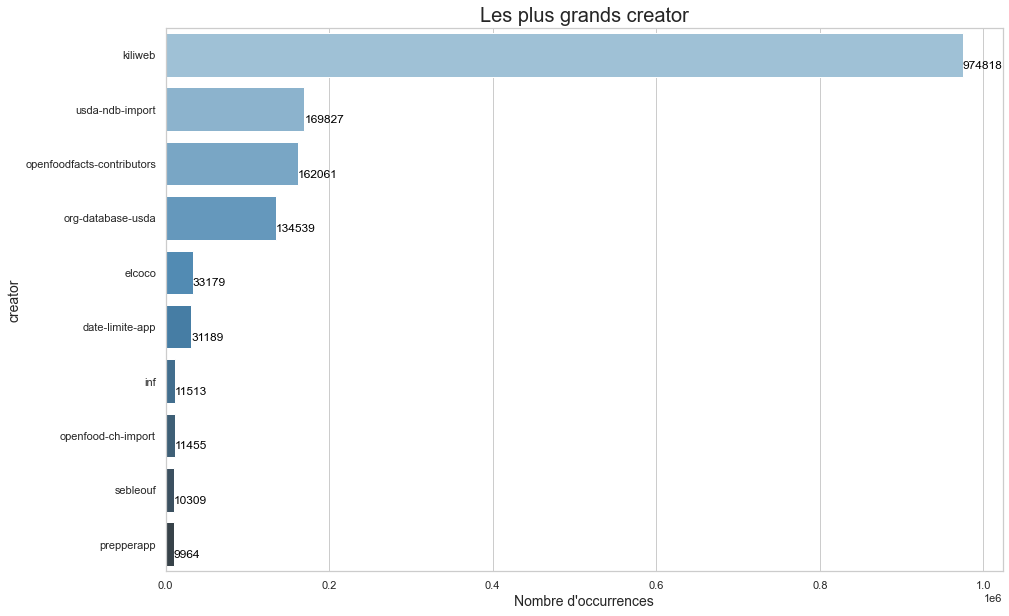

Nombre d'enregistrements vides pour creator: 4 (0.00022968269909327013%)
nunique      13382
count      1741529
size       1741533
Name: creator, dtype: int64


In [14]:
# Get top 10 Contributors
df_10_contributors = get_top_10(df, 'creator')

# Show Result
print('\nLes 10 premiers contributeurs (en nombre et en pourcentage)')
print(df_10_contributors)
show_plot(df_10_contributors, 'creator')

# Show Information about empty records
print_stats(df, 'creator')

Après avoir chargé et explorer légèrement les nous pouvons commencer à identifier qui sont les contributeurs : https://fr.openfoodfacts.org/contributeurs

Pouvons-nous leur faire confiance ? 

Une grande partie des données a été générée par kiliweb. Approximativement 55%. Qui est-ce ?

Kiliweb semble être une agence web en France.

#### Aperçu du moment où les produits ont été créés par les contributeurs

,creator,mod_datetime
0,kiliweb,2018
2,kiliweb,2019
4,openfoodfacts-contributors,2019
5,kiliweb,2018
6,kiliweb,2018
...,...,...
1741528,kiliweb,2020
1741529,kiliweb,2019
1741531,kiliweb,2020
1741532,kiliweb,2021


<AxesSubplot:title={'center':'Quand les produits ont-ils été créés ?'}, xlabel='mod_datetime'>

<AxesSubplot:title={'center':'Quand les produits ont-ils été créés ?'}, xlabel='mod_datetime'>

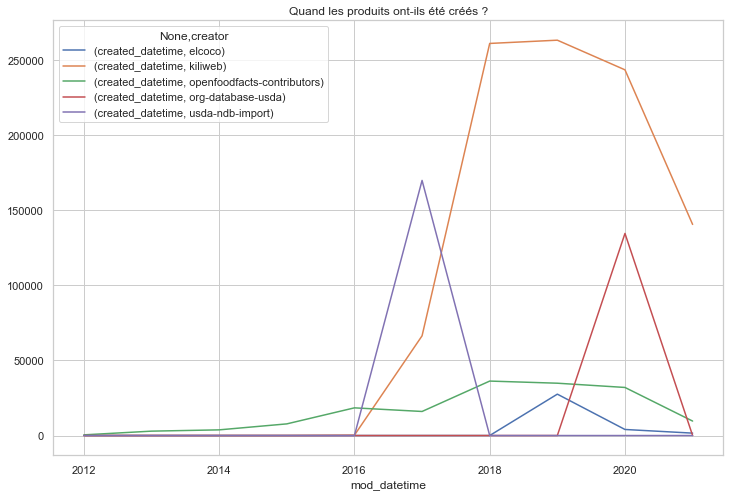

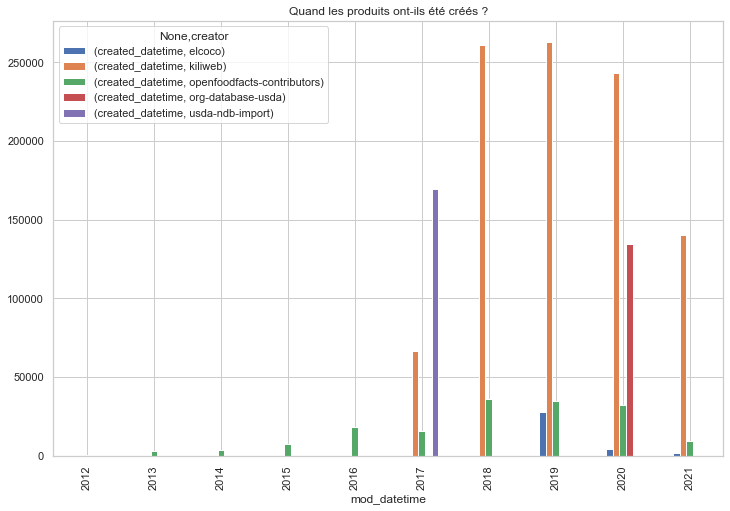

In [15]:
top_5_creators = df.loc[(df['creator'] == 'kiliweb') |
                        (df['creator'] == 'usda-ndb-import') |
                        (df['creator'] == 'openfoodfacts-contributors') |
                        (df['creator'] == 'org-database-usda') |
                        (df['creator'] == 'elcoco')][[
                            'creator', 'created_datetime'
                        ]]

top_5_creators['mod_datetime'] = top_5_creators['created_datetime'].apply(
    lambda x: x[0:4])
top_5_creators.drop('created_datetime', axis=1)

mod_pivot = pd.pivot_table(top_5_creators,
                           index=top_5_creators['mod_datetime'],
                           columns='creator',
                           aggfunc=len,
                           fill_value=0)
mod_pivot.plot(kind="line",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")
mod_pivot.plot(kind="bar",
               figsize=(12, 8),
               title="Quand les produits ont-ils été créés ?")

Jusqu'à présent, nous pouvons voir que Kiliweb est le contributeur le plus actif et ajoute continuellement des produits. C'est le contributeur le plus actif. La plupart des produits sont donc probablement principalement de France. 
Nous pouvons déjà supposer, sur la base des principaux contributeurs, que les produits français prédominent.

usda-ndb-import, qui est le 'United States Department of Agriculture' semble ne plus contribuer à la base de données open food facts et n'a été importé qu'une seule fois.

La communauté ouverte des contributeurs d'openfoodfacts semble s'agrandir au fil des années. La diversité des contributeurs peut conduire à des données non concordantes.

#### Les marques
Informations générales sur les marques


Les 10 premières marques (nombres et pourcentages)
              brands  Nombre  Pourcentage
20495      Carrefour   14320     0.822264
7410          Auchan   11241     0.645466
15064        Bonarea    6960     0.399648
127017             U    6185     0.355147
31793       Delhaize    4995     0.286816
52197      Hacendado    4904     0.281591
21246         Casino    4502     0.258508
90856         Nestlé    4340     0.249206
71810   Leader Price    4204     0.241397
27020           Coop    3469     0.199192


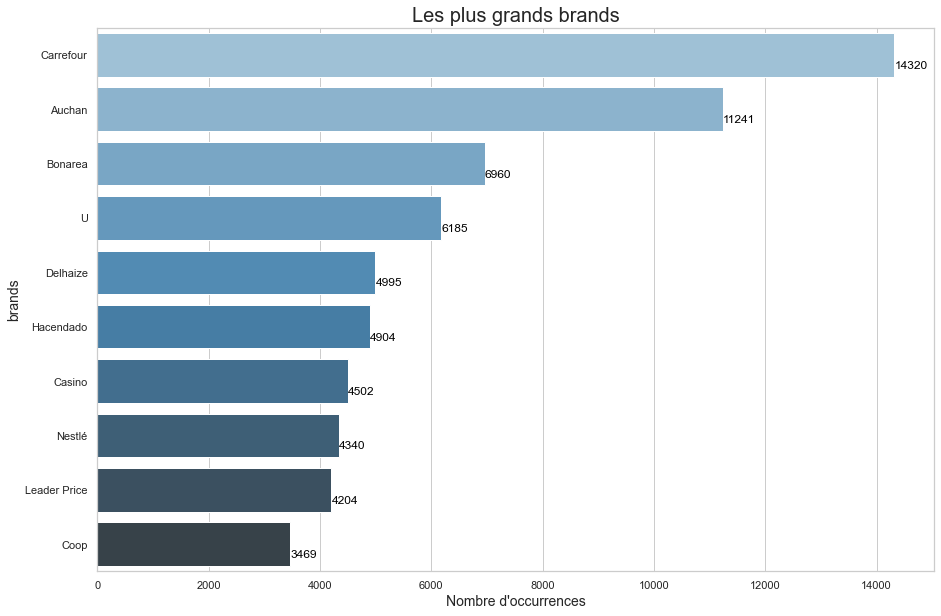

Nombre d'enregistrements vides pour brands: 832770 (47.81821533097564%)
nunique     160641
count       908763
size       1741533
Name: brands, dtype: int64


In [16]:
# Obtenir le top 10 des marques
df_10_brands = get_top_10(df, 'brands')

# Afficher le résultat
print('\nLes 10 premières marques (nombres et pourcentages)')
print(df_10_brands)
show_plot(df_10_brands, 'brands')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'brands')

48% des produits ne sont associés à aucune marque. En outre, les 6 plus grandes marques d'Open Food Facts sont Français.

Il semble que, comme décrit ci-dessus avec les contributeurs, la communauté française, à travers kiliweb, est le contributeur le plus important. Cela peut expliquer pourquoi il y a tant de produits assignés à la France.


Top 10 countries (Counts & Percentage)
          countries_fr  Nombre  Pourcentage
2215            France  719896    41.336914
3987        États-Unis  343086    19.700230
2092           Espagne  196916    11.307050
3193            Italie   61439     3.527869
123          Allemagne   59186     3.398500
972           Belgique   47760     2.742411
3758            Suisse   45303     2.601329
3557       Royaume-Uni   38649     2.219252
1741            Canada   27515     1.579930
2219  France,Allemagne   11781     0.676473


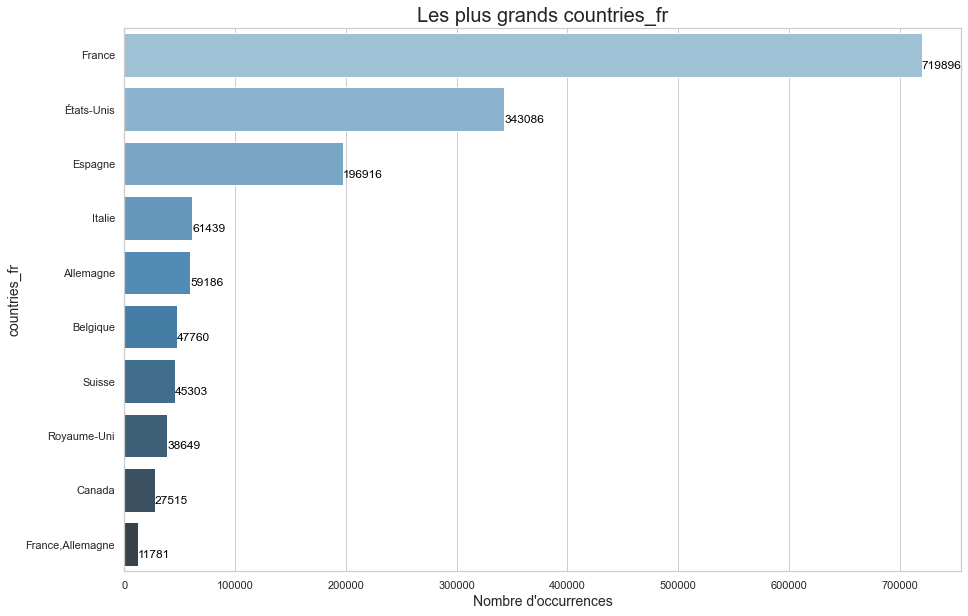

Nombre d'enregistrements vides pour countries_fr: 5482 (0.3147801391073267%)
nunique       4005
count      1736051
size       1741533
Name: countries_fr, dtype: int64


In [17]:
# Obtenir le top 10 de countries_fr
df_10_countries_fr = get_top_10(df, 'countries_fr')

# Afficher le résultat
print('\nTop 10 countries (Counts & Percentage)')
print(df_10_countries_fr)
show_plot(df_10_countries_fr, 'countries_fr')

# Afficher des informations sur les NaNs
print_stats(df, 'countries_fr')

Nous découvrons ici le même comportement que l'analyse précédente. La plupart des produits sont attribués à la France, ce qui était attendu puisque le principal contributeur est kiliweb une agence web française. Ceci est cohérent, surtout après l'analyse des contributeurs et des marques ci-dessus.

Même si la plupart des produits ont été assignés à un pays, 5482 produits ne sont liés à aucun pays et qu'il y a 4005 pays.

Jusqu'à présent, il semble que les pays contiennent une liste de pays et non un pays unique comme en témoigne la 10e ligne "France,Allemagne".

De plus, la plupart des produits sont liés à un ou deux pays seulement, ce qui est très suspect. Nous pourrions par exemple supposer sans le moindre doute que cette confiture à la fraise de l'Oregon https://fr.openfoodfacts.org/produit/0011110901422/oregonstrawberry-kroger attribué à la France a été fondée aux USA puisque c'est là où se situe l'Oregon et qu'il est fabriqué par Kroger https://fr.wikipedia.org/wiki/Kroger.

<img src="https://static.openfoodfacts.org/images/products/001/111/090/1422/front_fr.4.full.jpg"></img>

Très probablement, ce produit est vendu en France et a été répertorié comme produit français. Mais nous pouvons être sûrs que cette confiture est également vendu aux Etats-Unis, peut-être sous un autre nom de produit.

Jusqu'à présent, nous pouvons conclure que ce champ pays doit être utilisé avec précaution pour fournir une analyse de produits français ou vendu en France aux agents de Santé Publique France.


Top 10 des origines (nombres et pourcentages)
               origins  Nombre  Pourcentage
3267            France   18902     1.085366
6058            México    1886     0.108295
8875  Union Européenne    1603     0.092045
2709            España    1450     0.083260
4877            Italie    1332     0.076484
2638           Espagne    1242     0.071316
2235       Deutschland    1076     0.061785
8951  Union européenne     988     0.056732
4989             Italy     809     0.046453
4848            Italia     807     0.046338


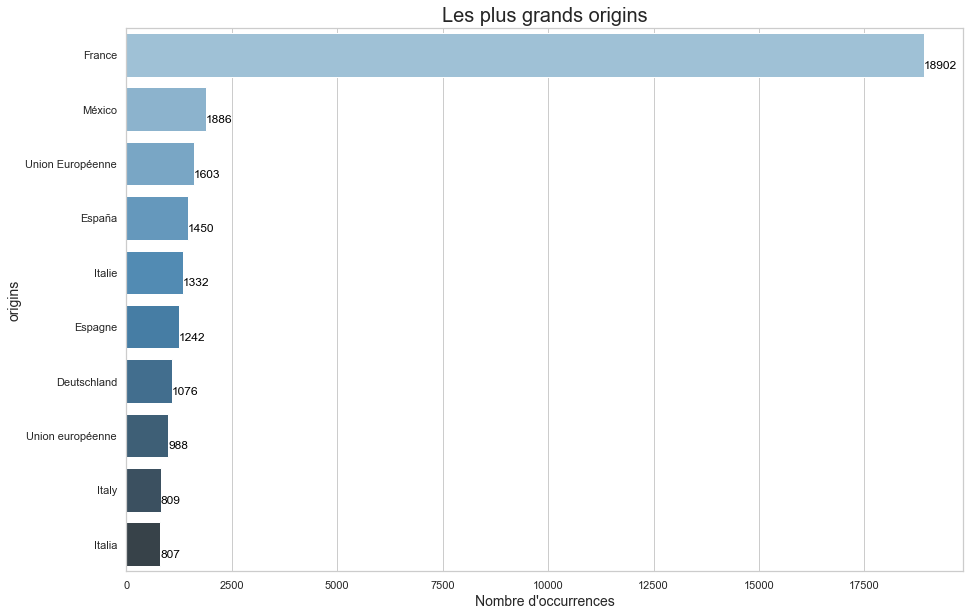

Nombre d'enregistrements vides pour origins: 1666000 (95.66284417234701%)
nunique      12389
count        75533
size       1741533
Name: origins, dtype: int64


In [18]:
# Obtenir le top 10 des origines
df_10_origins = get_top_10(df, 'origins')

# Afficher le résultat
print('\nTop 10 des origines (nombres et pourcentages)')
print(df_10_origins)
show_plot(df_10_origins, 'origins')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'origins')

Les origines sont très dénormalisées et peuvent contenir comme valeur un pays une région ou un continent,... 12389 valeurs uniques, c'est beaucoup plus que la liste des pays potentiels.

Cela rend l'utilisation de ce champ difficile.

#### Catégorie principale

Nous cherchons à savoir quelles sont les principales catégories (nombre/pourcentage/NaNs).


Top 10 des principales catégories (nombres et pourcentages)
          main_category_fr  Nombre  Pourcentage
13764               Snacks   32884     1.888221
13040               Sauces   16013     0.919477
3575           Confiseries   15262     0.876354
5866              Fromages   14652     0.841328
1142              Biscuits   14638     0.840524
1609              Boissons    9314     0.534816
4665       Desserts glacés    9238     0.530452
9838                 Pains    8999     0.516729
22489     en:salted-snacks    7684     0.441220
4467   Céréales et dérivés    7402     0.425028


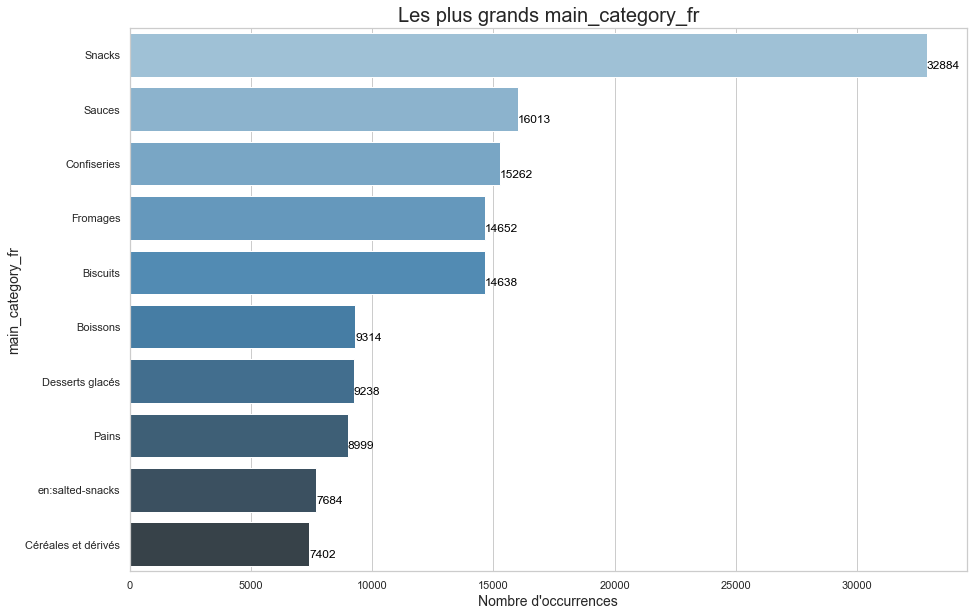

Nombre d'enregistrements vides pour main_category_fr: 905959 (52.020777096959975%)
nunique      28838
count       835574
size       1741533
Name: main_category_fr, dtype: int64


In [19]:
# Obtenir le top 10 Catégorie principale
df_10_main_category_fr = get_top_10(df, 'main_category_fr')

# Show Result
print('\nTop 10 des principales catégories (nombres et pourcentages)')
print(df_10_main_category_fr)
show_plot(df_10_main_category_fr, 'main_category_fr')

# Afficher des informations sur les enregistrements vides
print_stats(df, 'main_category_fr')

Il semble que 52% des produits n'ont pas de catégorie.

#### Identification des variables numériques

In [20]:
# Obtenir une liste pour les variables numériques uniquement
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
created_t,1741533.0,1.550696e+09,4.993390e+07,1.328021e+09,1.518964e+09,1.561572e+09,1.587667e+09,1.618708e+09
last_modified_t,1741533.0,1.585857e+09,2.855156e+07,1.333873e+09,1.576526e+09,1.587663e+09,1.607760e+09,1.618708e+09
serving_quantity,460930.0,2.410585e+16,1.636590e+19,0.000000e+00,2.800000e+01,5.000000e+01,1.130000e+02,1.111111e+22
additives_n,685544.0,2.046187e+00,2.919098e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.900000e+01
ingredients_from_palm_oil_n,685544.0,2.062596e-02,1.439338e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
ingredients_that_may_be_from_palm_oil_n,685544.0,6.907799e-02,3.009657e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
nutriscore_score,650486.0,9.182527e+00,8.895505e+00,-1.500000e+01,2.000000e+00,1.000000e+01,1.600000e+01,4.000000e+01
nova_group,599607.0,3.431875e+00,9.636102e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
energy-kj_100g,126273.0,5.278689e+37,1.875777e+40,0.000000e+00,4.000000e+02,9.760000e+02,1.617000e+03,6.665559e+42
energy-kcal_100g,1329062.0,6.541628e+06,7.541188e+09,0.000000e+00,1.010000e+02,2.630000e+02,4.000000e+02,8.693855e+12


Nous pouvons identifier quelques thèmes :

- Les macronutriments avec leurs multiples niveaux de décomposition : glucides, lipides, protéines.
- les micronutriments : minéraux, vitamines
- Le score énergétique et nutritionnel (qui pourrait être utilisé comme variable cible pour construire un modèle).

Nous pouvons également remarquer que :

- Nous avons très peu de données pour les niveaux de décomposition. Nous pourrions probablement abandonner toutes ces variables ou les conserver malgré tout pour mener une étude approfondie sur les carences.
- Les données sont normalisées sur 100 grammes. Il y a quelques valeurs négatives et des valeurs supérieures à 100 à nettoyer.
- Le score nutritionnel va de -15 à 40 (cela semble d’après le site santé publique)
- L’énergie est exprimée en kilojoules.

Faisons un peu de nettoyage :

Nous allons supprimer les observations dont les valeurs sont incohérentes. Nous pourrions décider de remplacer les valeurs négatives par 0, étant donné la nature du projet, les observations avec des données incohérentes sont probablement de mauvaises entrées et nous avons aussi plus que suffisamment de données.


### Nettoyage des données

Cette partie, contient toutes les activités de nettoyage des données, effectuées sur le fichier fr.openfoodfacts.org.products.csv. Le but de cette partie est de nettoyer les données et de les enrichir en fonction des activités requises. Qui est, pour rappel, fournir des données de santé plus accessible pour les agents de santé publique.

Avant d'effectuer toute analyse, il est en effet important de disposer d'un ensemble de données consolidées correctes. En effet, nous découvrons que l'ensemble de données nécessite beaucoup d'activités de nettoyage et que la qualité des données est parfois médiocre.

#### Les objets
Nettoyons les données comme indiqué ci-dessus. Nous restons très conservateurs.

In [21]:
# Définir le sous-ensemble de variables dans lequel
# nous ne voulons pas de données manquantes.
subset = [
    'code', 'creator', 'created_datetime', 'last_modified_datetime',
    'product_name', 'states_tags'
]

# Supprimer les lignes avec
# des données manquantes dans ce sous-ensemble.
df.dropna(subset=subset, inplace=True)

# Supprimer les nouvelles variables avec des données
# manquantes qui apparaissent après la suppression précédente.
df.dropna(how='all', axis=1, inplace=True)

print('Forme du jeu de données: {}'.format(df.shape))

Forme du jeu de données: (1664009, 178)


Réduction du nombre de lignes à 1 664 003.

Nous cherchons à savoir s'il y a d'autres anomalies dans les données. Nous examinons la qualité des données pour comprendre ce qui pourrait être utilisé pour une analyse plus approfondie.

Nous avons identifié quelques doublons comme indiqué ci-dessus, qui devraient être nettoyés/supprimés, une fois clairement identifiés.

In [22]:
df[df.duplicated(subset='code')].head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
633814,30383354190402,http://world-fr.openfoodfacts.org/produit/3038...,openfoodfacts-contributors,1608035756,2020-12-15T12:35:56Z,1610702583,2021-01-15T09:23:03Z,basilic,NaN,NaN,...,NaN,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015382,3770008983205,http://world-fr.openfoodfacts.org/produit/3770...,r-x,1614201389,2021-02-24T21:16:29Z,1614242412,2021-02-25T08:40:12Z,REMYX VODKA Aquatique,NaN,Vodka,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1389391,7798049540559,http://world-fr.openfoodfacts.org/produit/7798...,openfoodfacts-contributors,1615222625,2021-03-08T16:57:05Z,1615337611,2021-03-10T00:53:31Z,lentejas,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Suppression des doublons dans la colonne code
df.drop_duplicates('code', keep=False, inplace=True)

In [24]:
# Définir code comme index
df.set_index('code', inplace=True)

In [27]:
# Convertir les variables d'objet created_datetime
# et last_modified_datetime en variables de type datetime.
df.created_datetime = pd.to_datetime(df.created_datetime)
df.last_modified_datetime = pd.to_datetime(df.last_modified_datetime)

df.created_datetime.head()

code
0000000000100          2015-10-11 14:09:21+00:00
00000000001111111111   2019-06-08 18:56:13+00:00
0000000000123          2018-08-31 17:53:02+00:00
0000000000208          2018-12-07 18:34:40+00:00
000000000054           2020-02-24 18:30:31+00:00
Name: created_datetime, dtype: datetime64[ns, UTC]

#### Les variables numériques
Nettoyons les données comme indiqué ci-dessus.

Nous allons maintenant éliminer toutes les lignes, qui contiennent des valeurs impossibles par définition.

Une inspection des valeurs min et max révèle qu'il y a des erreurs évidentes dans nos données.

In [28]:
# Supprimer les observations dont les
# éléments x_100g ont des valeurs négatives
obs_with_negative_facts = (df.loc[:, 'fat_100g':'chlorophyl_100g'] < 0).any(
    axis=1)
df.drop(df[obs_with_negative_facts].index, inplace=True)

# Supprimer les observations x_100g qui ont une valeur supérieure à 100g
obs_with_facts_over_100 = (df.loc[:, 'fat_100g':'chlorophyl_100g'] > 100).any(
    axis=1)
df.drop(df[obs_with_facts_over_100].index, inplace=True)

# Supprimer les observations dont la somme de
# lipide + glucide + protéine ont une valeur supérieure à 100g
df[(df['fat_100g'] + df['carbohydrates_100g'] + df['proteins_100g']) <= 100]

print('Produit avec la valeur minimale: {}'.format(
    df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'min'].min()))
print('Produit avec la valeur maximale: {}'.format(
    df.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'max'].max()))
print('Forme du jeu de données: {}'.format(df.shape))

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000100,http://world-fr.openfoodfacts.org/produit/0000...,del51,1444572561,2015-10-11 14:09:21+00:00,1444659212,2015-10-12 14:13:32+00:00,moutarde au moût de raisin,NaN,NaN,100g,...,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1535737982,2018-08-31 17:53:02+00:00,1535737986,2018-08-31 17:53:06+00:00,Sauce Sweety chili 0%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000001137,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1539781575,2018-10-17 13:06:15+00:00,1539781578,2018-10-17 13:06:18+00:00,Baguette parisien,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000000000114,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1580066482,2020-01-26 19:21:22+00:00,1609945229,2021-01-06 15:00:29+00:00,Chocolate n 3,NaN,NaN,80 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000001151,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1537883404,2018-09-25 13:50:04+00:00,1537883538,2018-09-25 13:52:18+00:00,&quot;Baguette Lyonnais&quot;,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999999004360,http://world-fr.openfoodfacts.org/produit/9999...,kiliweb,1548086277,2019-01-21 15:57:57+00:00,1558357406,2019-05-20 13:03:26+00:00,Minis beignets,NaN,Beignets natures sucrés,NaN,...,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999999175305,http://world-fr.openfoodfacts.org/produit/9999...,sil,1577002381,2019-12-22 08:13:01+00:00,1596533045,2020-08-04 09:24:05+00:00,Erdbeerkuchen 1019g tiefgefroren,NaN,NaN,"1,019 kg",...,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999999901,http://world-fr.openfoodfacts.org/produit/9999...,kiliweb,1585068504,2020-03-24 16:48:24+00:00,1585068505,2020-03-24 16:48:25+00:00,Scs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Produit avec la valeur minimale: 0.0
Produit avec la valeur maximale: 100.0
Forme du jeu de données: (902638, 177)


Au cours de ce processus, nous avons abandonné 761 365 observations.

#### Filtrer les produits disponible en France

In [29]:
countries_filter = df['countries_tags'].astype(dtype='str').str.split(',')
df_fr = df[countries_filter.apply(lambda lang: 'en:france' in lang)]
df_fr.shape

(422264, 177)

Dans cette dataframe nous abandonnons 480 374 observations.

#### Les valeurs manquantes

Regardons plus en détail les valeurs manquantes, l'ensemble de données est très clairsemé mais nous allons en avoir un meilleur aperçu en traçant un histrogramme du pourcentage de valeurs manquantes par variables, empilées par type (objet et nombre) et aussi un histrogramme du pourcentage de valeurs manquantes par observation.

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Pourcentage de valeurs NaN')

Text(0, 0.5, '# Variable')

Text(0.5, 1.0, 'Distribution des valeurs NaN par variable, empilées par type de variable')

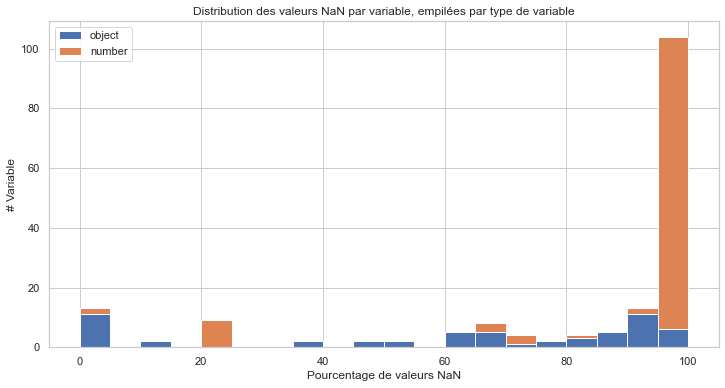

In [30]:
# Distribution des valeurs manquantes par variable,
# empilées par type de variable
nan_counts_object_vars = df_fr.select_dtypes(
    'object').isnull().sum() / df_fr.shape[0] * 100
nan_counts_number_vars = df_fr.select_dtypes(
    'number').isnull().sum() / df_fr.shape[0] * 100

pd.DataFrame({'object': nan_counts_object_vars, 'number': nan_counts_number_vars}) \
  .plot.hist(stacked=True, bins=20, figsize=(12, 6))

plt.xlabel('Pourcentage de valeurs NaN')
plt.ylabel('# Variable')
plt.title(
    'Distribution des valeurs NaN par variable, empilées par type de variable')
plt.show()

Il est clair que nous avons des variables avec des valeurs essentiellement manquantes mais nous devons nous demander ce que signifie avoir des valeurs manquantes dans une variable objet et une variable numérique du point de vue du domaine :

- Les variables objet sont essentiellement des données qui décrivent les produits ou permettent de les classer. À un haut niveau, les valeurs manquantes signifient que la fiche produit est incomplète. Par exemple, si nous sommes intéressés par les groupes de produits, nous travaillerons au mieux avec environ 1/3 de l'ensemble de données.

- La plupart des variables numériques sont des faits alimentaires. Certains faits sont simplement moins actuels que d'autres ; s'il est presque impossible de trouver un produit sans indication sur les graisses, il sera plus difficile d'en trouver un avec du fer par exemple. Étant donné que l'ensemble de données présente les informations sur les aliments sous une forme non empilée, nous disposons de données très éparses. Dans ce cas, les variables présentant un grand nombre de valeurs manquantes ne sont pas synonymes de mauvaises variables, bien au contraire. Si nous voulions analyser les aliments pour bébés à différents âges, ces faits/variables rares seraient probablement très utiles.

Enfin, l'élimination des variables doit être dictée par l'objectif que nous avons. Pour l'analyse que feront les agents, l'idéal est ne pas supprimer de variables du tout, ou utiliser une simple règle de seuil NaN, même si en réalité nous pouvons continuer ce projet en toute sécurité. Nous avons un grand ensemble de données, mais il pourrait être beaucoup plus grand.
Le mieux est la stratégie consistant à construire un nouveau dataframe à partir de la source plutôt que de réduire la forme du dataframe source.

Notez que même 5% de valeurs non nulles dans une variable d'une dataframe de produits vendu en France représentent environ 21 113 observations.

In [31]:
# Voici une fonction pour faciliter l'exploration :
# Obtenir les variables pour lesquelles le pourcentage
# des valeurs manquantes se situe dans la fourchette basse et haute des %.
def get_variables_with_nan_in_range(data, low, high, dtypes):
    if high >= 100:
        high = 100.1

    nan_counts = data.select_dtypes(dtypes).isnull().sum()
    nan_counts_percent = nan_counts / data.shape[0] * 100

    filter = (nan_counts_percent >= low) & (nan_counts_percent < high)
    nan_counts = nan_counts[filter]
    nan_counts_percent = nan_counts_percent[filter]
    counts = data.shape[0] - nan_counts
    counts_percent = 100 - nan_counts_percent

    return pd.DataFrame({
        'nombre': counts,
        'nombre %': counts_percent,
        'nombre de NaN': nan_counts,
        'nombre de NaN %': nan_counts_percent
    })


# Food facts with NaN
get_variables_with_nan_in_range(df_fr, 0, 95, 'number')

,nombre,nombre %,nombre de NaN,nombre de NaN %
created_t,422264,100.000000,0,0.000000
last_modified_t,422264,100.000000,0,0.000000
serving_quantity,41856,9.912282,380408,90.087718
additives_n,131163,31.061848,291101,68.938152
ingredients_from_palm_oil_n,131163,31.061848,291101,68.938152
ingredients_that_may_be_from_palm_oil_n,131163,31.061848,291101,68.938152
nutriscore_score,123497,29.246396,298767,70.753604
nova_group,107594,25.480268,314670,74.519732
energy-kj_100g,36018,8.529735,386246,91.470265
energy-kcal_100g,322925,76.474670,99339,23.525330


Dans la fourchette 0-95% de valeurs manquantes, nous avons des variables pour les macronutriments (glucides/lipides/protéines) et le premier niveau des minéraux et vitamines les plus courants. Il nous manque l'amidon, les polyols pour le premier niveau de répartition des glucides; la caséine et les protéines sériques pour les protéines.

<AxesSubplot:>

(0.0, 100.0)

(0.0, 130000.0)

Text(0.5, 0, 'Pourcentage des valeurs NaN')

Text(0, 0.5, '# Observations')

Text(0.5, 1.0, 'Distribution des valeurs NaN par observation')

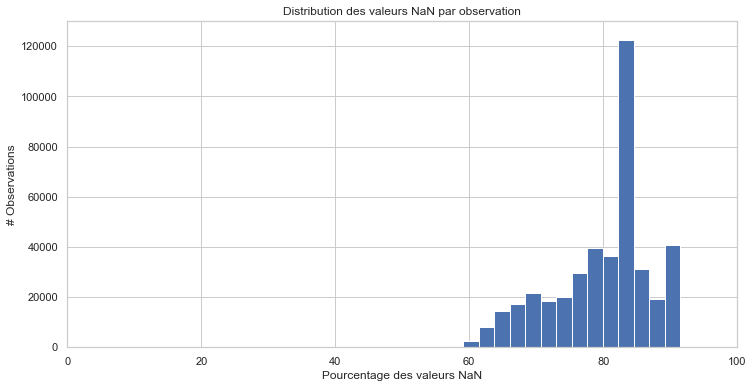

In [32]:
# Distribution des valeurs manquantes par observation
nan_counts_obs = df_fr.isnull().sum(axis=1) / df_fr.shape[1] * 100
nan_counts_obs.hist(bins=20, figsize=(12, 6))

plt.xlim((0, 100))
plt.ylim((0, 130000))
plt.xlabel('Pourcentage des valeurs NaN')
plt.ylabel('# Observations')
plt.title('Distribution des valeurs NaN par observation')
plt.show()

Concernant les valeurs manquantes par observation, il est intéressant de voir ce pic énorme autour de 85% de valeurs manquantes. Il serait intéressant de faire le lien avec la variable `creator` pour voir s'il y a une relation.

#### Récapitulatif

En résumé, dans cette première partie, nous avons acquis une meilleure compréhension des données et de leur structure. Nous avons effectué un nettoyage de sécurité et de base. Nous avons décidé de conserver toutes les variables avec les données car les variables présentant un grand nombre de valeurs manquantes ne sont pas synonymes de mauvaises variables et pourront servir pour des analyses.

Dans les sections suivantes, nous construirons des sous-ensembles de données dédiés pour mener nos différentes analyses.

À ce stade, nous disposons d'une base de données source de produits disponibles en France avec laquelle nous pouvons travailler de manière suffisament sereine. Bien sûr, il ne s'agit que d'une première itération de nettoyage et nous devrons nettoyer les données plus en profondeur dans les prochaines sections.